# Машинное обучение, ФКН ВШЭ

# Семинар 22

In [1]:
import numpy as np
import pandas as pd
import nltk
from bs4 import BeautifulSoup
import re
import os
import codecs
from sklearn import feature_extraction
import mpld3
%matplotlib inline

# Анализ текстов

Ранее мы изучали интуитивно простые способы формирования признаков для текстов, такие как векторизация и tf-idf — как правило, эти методы используются в задачах обучения с учителем, где похожие объекты имеют свою строгую специфику и радикально отличаются от объектов других классов (например, задача определения спам-писем).

Однако иногда после получения выборки необходимо узнать больше о природе корпуса текстов для успешного решения исходной задачи, поэтому семинар будет посвящен применению изученных нами в курсе unsupervised методов к выборкам текстов.

## Данные

В качестве корпуса текстов в нашем случае будет выступать выборка, состоящая из синопсисов к 100 лучшим фильмам всех времён по версии IMDB. Попробуем при помощи изученых методов выявить причины, по которым данные фильмы вызывают повышенный интерес.

Загрузим названия, синопсисы (с IMDB и Википедии) и жанры фильмов:

In [2]:
#import three lists: titles, links and wikipedia synopses
titles = open('data/title_list.txt').read().split('\n')

#ensures that only the first 100 are read in
titles = titles[:100]

links = open('data/link_list_imdb.txt').read().split('\n')
links = links[:100]

synopses_wiki = open('data/synopses_list_wiki.txt').read().split('\n BREAKS HERE')
synopses_wiki = synopses_wiki[:100]

synopses_clean_wiki = []
for text in synopses_wiki:
    text = BeautifulSoup(text, 'html.parser').getText()
    #strips html formatting and converts to unicode
    synopses_clean_wiki.append(text)

synopses_wiki = synopses_clean_wiki
    
    
genres = open('data/genres_list.txt').read().split('\n')
genres = genres[:100]

print(str(len(titles)) + ' titles')
print(str(len(links)) + ' links')
print(str(len(synopses_wiki)) + ' synopses')
print(str(len(genres)) + ' genres')

100 titles
100 links
100 synopses
100 genres


In [3]:
synopses_imdb = open('data/synopses_list_imdb.txt').read().split('\n BREAKS HERE')
synopses_imdb = synopses_imdb[:100]

synopses_clean_imdb = []

for text in synopses_imdb:
    text = BeautifulSoup(text, 'html.parser').getText()
    #strips html formatting and converts to unicode
    synopses_clean_imdb.append(text)

synopses_imdb = synopses_clean_imdb

In [4]:
synopses = [synopses_wiki[i] + synopses_imdb[i] for i in range(len(synopses_wiki))]
ranks = np.arange(100).tolist()

## Предобработка данных

Как и ранее, текстовые данные требуют тщательной предобработки — в частности, необходимо произвести:
 * токенизацию (разбиение текста на термины);
 * удаление стоп-слов (часто встречающиеся всюду слова не оказывают важного влияния на смысловую составляющую текста, а потому могут быть опущены);
 * лемматизацию/стемминг (для устранения влияния склонений, спряжений и пр.).

In [5]:
# load nltk's English stopwords
stopwords = nltk.corpus.stopwords.words('english')

In [6]:
# load nltk's SnowballStemmer
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

In [7]:
def tokenize_and_preprocess(text, stem=True):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    if stem:
        filtered_tokens = [stemmer.stem(t) for t in filtered_tokens]
    return filtered_tokens

Создадим словари всех токенов из корпуса с использованием стемминга и без:

In [8]:
totalvocab_stemmed = []
totalvocab_tokenized = []

for i in synopses:
    allwords_stemmed = tokenize_and_preprocess(i)
    totalvocab_stemmed.extend(allwords_stemmed)
    
    allwords_tokenized = tokenize_and_preprocess(i, stem=False)
    totalvocab_tokenized.extend(allwords_tokenized)

Посмотрим на результаты стемминга слов из корпуса:

In [9]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
vocab_frame

,words
plot,Plot
edit,edit
edit,edit
edit,edit
on,On
the,the
day,day
of,of
his,his
onli,only


Как правило, стемминг показывает неплохие результаты для английских текстов в отличие от русских в силу особенностей морфологии русского языка.

## tf-idf


Для начала используем уже известные нам методы — преобразуем тексты при помощи tf-idf и вычислим расстояние между полученными векторами для дальнейшей кластеризации и визуализации. В качестве функции расстояния будем использовать $\rho (x, z) = 1 - cosine(x, z),$ где $cosine(x, z)$ — косинусная мера между векторами $x, z$.

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2, stop_words='english',
                                 use_idf=True, tokenizer= (lambda x: tokenize_and_preprocess(x)), ngram_range=(1,3))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(synopses)
terms = tfidf_vectorizer.get_feature_names()
print(tfidf_matrix.shape)

CPU times: user 13.5 s, sys: 237 ms, total: 13.7 s
Wall time: 14 s
(100, 563)


In [11]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)
dist = np.maximum(np.zeros(dist.shape), dist) # overriding precision errors
pd.DataFrame(dist)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.000000,0.800540,0.762813,0.754917,0.734714,0.798842,0.579230,7.406224e-01,7.205814e-01,0.875165,...,0.634593,0.744356,0.729301,0.800025,0.664344,0.664176,0.773151,0.641312,6.705782e-01,0.823926
1,0.800540,0.000000,0.733478,0.825432,0.767897,0.705784,0.735097,8.080429e-01,7.768603e-01,0.872037,...,0.721570,0.529899,0.798735,0.831396,0.812697,0.881068,0.817880,0.733118,7.716092e-01,0.892975
2,0.762813,0.733478,0.000000,0.813207,0.710407,0.786592,0.604588,7.714040e-01,7.813395e-01,0.837482,...,0.796111,0.792054,0.774655,0.836437,0.800423,0.900050,0.817346,0.723807,7.494897e-01,0.858673
3,0.754917,0.825432,0.813207,0.000000,0.823794,0.824472,0.716148,6.918142e-01,8.722325e-01,0.876853,...,0.818708,0.780351,0.745104,0.800379,0.813221,0.822593,0.796196,0.765148,7.694794e-01,0.876888
4,0.734714,0.767897,0.710407,0.823794,0.000000,0.694266,0.660453,7.538627e-01,7.388473e-01,0.881802,...,0.671814,0.782382,0.734990,0.813092,0.614949,0.782968,0.766356,0.605218,6.320344e-01,0.804208
5,0.798842,0.705784,0.786592,0.824472,0.694266,0.000000,0.750991,7.868591e-01,7.226483e-01,0.854346,...,0.772842,0.641621,0.762121,0.748385,0.811850,0.867853,0.718264,0.669482,6.563999e-01,0.922110
6,0.579230,0.735097,0.604588,0.716148,0.660453,0.750991,0.000000,6.537296e-01,6.315202e-01,0.802409,...,0.671313,0.709579,0.686691,0.621620,0.671187,0.771724,0.739278,0.604365,6.278072e-01,0.778311
7,0.740622,0.808043,0.771404,0.691814,0.753863,0.786859,0.653730,2.220446e-16,8.273514e-01,0.794043,...,0.764814,0.689357,0.715340,0.740639,0.747380,0.807657,0.767651,0.763425,6.962482e-01,0.823697
8,0.720581,0.776860,0.781339,0.872233,0.738847,0.722648,0.631520,8.273514e-01,3.330669e-16,0.841057,...,0.755200,0.762186,0.742391,0.786411,0.794418,0.887258,0.769376,0.704912,6.673681e-01,0.846397
9,0.875165,0.872037,0.837482,0.876853,0.881802,0.854346,0.802409,7.940427e-01,8.410573e-01,0.000000,...,0.817777,0.831667,0.793370,0.879104,0.831353,0.876718,0.870285,0.836936,7.621334e-01,0.942701


На основе полученных расстояний для каждого фильма можно найти самые близкие к нему, основываясь на множестве слов каждого синопсиса:

In [12]:
film_number = 0

print(titles[film_number])
print([titles[i] for i in dist[film_number, :].argsort()[:10]])

The Godfather
['The Godfather', 'The Godfather: Part II', 'Goodfellas', 'Giant', 'Doctor Zhivago', 'Gladiator', 'Gone with the Wind', 'Saving Private Ryan', 'The Pianist', 'On the Waterfront']


## Кластеризация при помощи K-means

Основываясь на построенных признаках, попробуем кластеризовать фильмы при помощи метода K-means.

In [13]:
from sklearn.cluster import KMeans

num_clusters = 5

km = KMeans(n_clusters=num_clusters, random_state=5)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

CPU times: user 127 ms, sys: 2.29 ms, total: 129 ms
Wall time: 132 ms


In [14]:
import pandas as pd

films = { 'title': titles, 'rank': ranks, 'synopsis': synopses, 'cluster': clusters, 'genre': genres }
frame = pd.DataFrame(films, index = [clusters] , columns = ['rank', 'title', 'cluster', 'genre'])
frame

,rank,title,cluster,genre
2,0,The Godfather,2,"[u' Crime', u' Drama']"
3,1,The Shawshank Redemption,3,"[u' Crime', u' Drama']"
1,2,Schindler's List,1,"[u' Biography', u' Drama', u' History']"
2,3,Raging Bull,2,"[u' Biography', u' Drama', u' Sport']"
3,4,Casablanca,3,"[u' Drama', u' Romance', u' War']"
2,5,One Flew Over the Cuckoo's Nest,2,[u' Drama']
3,6,Gone with the Wind,3,"[u' Drama', u' Romance', u' War']"
2,7,Citizen Kane,2,"[u' Drama', u' Mystery']"
3,8,The Wizard of Oz,3,"[u' Adventure', u' Family', u' Fantasy', u' Mu..."
3,9,Titanic,3,"[u' Drama', u' Romance']"


Посмотрим на количество фильмов в каждом кластере и их средний ранг:

In [15]:
frame['cluster'].value_counts()

2    35
1    21
3    20
0    17
4     7
Name: cluster, dtype: int64

In [16]:
grouped = frame['rank'].groupby(frame['cluster'])

grouped.mean()

cluster
0    58.647059
1    47.285714
2    50.314286
3    39.150000
4    59.428571
Name: rank, dtype: float64

Можно заметить, что средний ранг фильмов в кластерах 1 и 3 меньше, чем в остальных, что значит, что в эти кластеры вошли фильмы, которые в среднем лучше, чем остальные. Посмотрим, какие слова характеризуют фильмы каждого кластера:

In [17]:
from __future__ import print_function

print("Top terms per cluster:")
print()
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    for ind in order_centroids[i, :6]:
        print(' %s' % vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
    print()
    print()
    print("Cluster %d titles:" % i, end='')
    for title in frame.ix[i]['title'].values.tolist():
        print(' %s,' % title, end='')
    print()
    print()

Top terms per cluster:

Cluster 0 words: car, film, Police, driving, house, room,

Cluster 0 titles: Psycho, Sunset Blvd., Vertigo, Chinatown, Singin' in the Rain, Some Like It Hot, Gandhi, The French Connection, Fargo, Network, Nashville, American Graffiti, Pulp Fiction, A Clockwork Orange, Wuthering Heights, Double Indemnity, North by Northwest,

Cluster 1 words: soldiers, Army, killed, command, general, orders,

Cluster 1 titles: Schindler's List, Lawrence of Arabia, The Bridge on the River Kwai, Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb, Apocalypse Now, The Lord of the Rings: The Return of the King, Gladiator, From Here to Eternity, Saving Private Ryan, Raiders of the Lost Ark, Patton, Butch Cassidy and the Sundance Kid, The Treasure of the Sierra Madre, Platoon, High Noon, Dances with Wolves, All Quiet on the Western Front, The Green Mile, Close Encounters of the Third Kind, Stagecoach, Mutiny on the Bounty,

Cluster 2 words: father, killed, New, Police,

Внутри каждого кластера можно заметить определенные паттерны — например, кластер 3 включает в основном фильмы про семью, а 1 — про войну и потери. Это подтверждается также и самыми популярными жанрами внутри кластера:

In [18]:
genre_set = set()

for i in range(frame.shape[0]):
    tmp = frame.iloc[i, -1][1:-1]
    genre_set |= set([genre.strip()[3:-1] for genre in tmp.split(',')])
genre_set = list(genre_set)

In [19]:
for genre in genre_set:
    frame['Is_genre_{}'.format(genre)] = frame['genre'].apply(lambda x: int(genre in x))

grouped = frame[frame.columns.tolist()[4:]].groupby(frame['cluster'], as_index=False).mean()

for i in range(num_clusters):
    print (i, [genre_set[num] for num in np.array(frame.iloc[i, 4:]).argsort()[-5:]])

0 ['Romance', 'Sci-Fi', 'Thriller', 'Crime', 'Drama']
1 ['Romance', 'Sci-Fi', 'Thriller', 'Crime', 'Drama']
2 ['Crime', 'Sci-Fi', 'Biography', 'History', 'Drama']
3 ['Sci-Fi', 'History', 'Biography', 'Sport', 'Drama']
4 ['Sci-Fi', 'History', 'War', 'Romance', 'Drama']


Однако также можно заметить, что разметка некоторых объектов кажется некорректной — такое происходит из-за того, что учитываются отдельные слова, а не темы, поэтому синонимы вноят некоторый хаос в полученную кластеризацию. Для выявления тем, которые порождают повышенный интерес к этому списку фильмов, необходимо использовать несколько другой подход.

## Визуализация кластеров

Визуализируем полученные ранее кластеры:

In [20]:
import os

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, metric="precomputed", random_state=1)

pos = tsne.fit_transform(dist)

xs, ys = pos[:, 0], pos[:, 1]

In [21]:
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}

cluster_names = {i: ','.join(['%s' % vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore') for ind in order_centroids[i, :6]])
                 for i in range(5)}

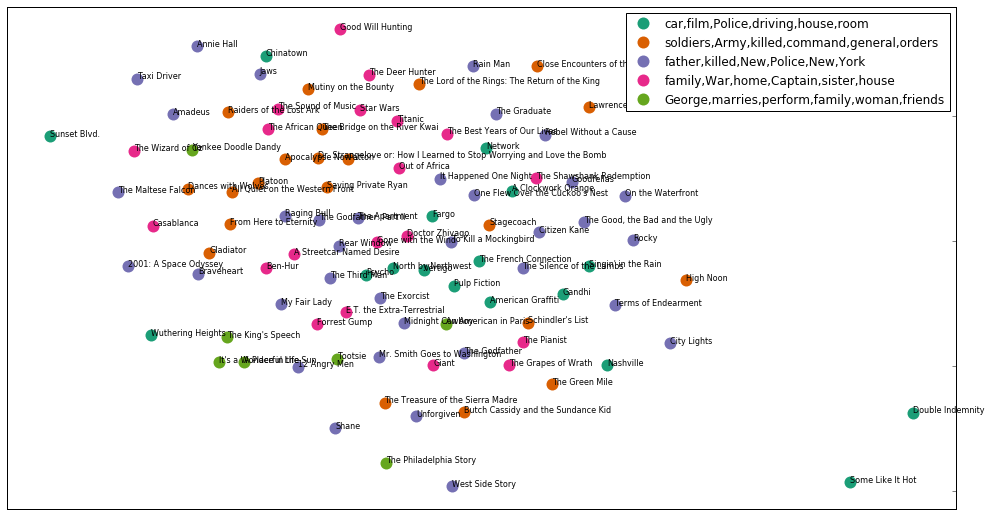

In [22]:
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 

groups = df.groupby('label')

fig, ax = plt.subplots(figsize=(17, 9))
ax.margins(0.05)

for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, label=cluster_names[name], color=cluster_colors[name], mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x', 
        which='both',
        bottom='off',
        top='off',
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',
        which='both',
        left='off',
        top='off',
        labelleft='off')
    
ax.legend(numpoints=1)

for i in range(len(df)):
    ax.text(df.ix[i]['x'], df.ix[i]['y'], df.ix[i]['title'], size=8)  

    
    
plt.show()

In [23]:
#define custom toolbar location
class TopToolbar(mpld3.plugins.PluginBase):
    """Plugin for moving toolbar to top of figure"""

    JAVASCRIPT = """
    mpld3.register_plugin("toptoolbar", TopToolbar);
    TopToolbar.prototype = Object.create(mpld3.Plugin.prototype);
    TopToolbar.prototype.constructor = TopToolbar;
    function TopToolbar(fig, props){
        mpld3.Plugin.call(this, fig, props);
    };

    TopToolbar.prototype.draw = function(){
      // the toolbar svg doesn't exist
      // yet, so first draw it
      this.fig.toolbar.draw();

      // then change the y position to be
      // at the top of the figure
      this.fig.toolbar.toolbar.attr("x", 150);
      this.fig.toolbar.toolbar.attr("y", 400);

      // then remove the draw function,
      // so that it is not called again
      this.fig.toolbar.draw = function() {}
    }
    """
    def __init__(self):
        self.dict_ = {"type": "toptoolbar"}

In [24]:
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 

#group by cluster
groups = df.groupby('label')

#define custom css to format the font and to remove the axis labeling
css = """
text.mpld3-text, div.mpld3-tooltip {
  font-family:Arial, Helvetica, sans-serif;
}

g.mpld3-xaxis, g.mpld3-yaxis {
display: none; }
"""

# Plot 
fig, ax = plt.subplots(figsize=(14,6)) #set plot size
ax.margins(0.03) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    points = ax.plot(group.x, group.y, marker='o', linestyle='', ms=18, label=cluster_names[name], mec='none', color=cluster_colors[name])
    ax.set_aspect('auto')
    labels = [i for i in group.title]
    
    #set tooltip using points, labels and the already defined 'css'
    tooltip = mpld3.plugins.PointHTMLTooltip(points[0], labels,
                                       voffset=10, hoffset=10, css=css)
    #connect tooltip to fig
    mpld3.plugins.connect(fig, tooltip, TopToolbar())    
    
    #set tick marks as blank
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
    
    #set axis as blank
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    
ax.legend(numpoints=1) #show legend with only one dot

mpld3.display() #show the plot

#uncomment the below to export to html
#html = mpld3.fig_to_html(fig)
#print(html)

## Иерархическая кластеризация

Попробуем оставить используемые признаки, основанных только на вхождениях определенных слов, и использовать другой метод кластеризации — например, иерархическую кластеризацию:

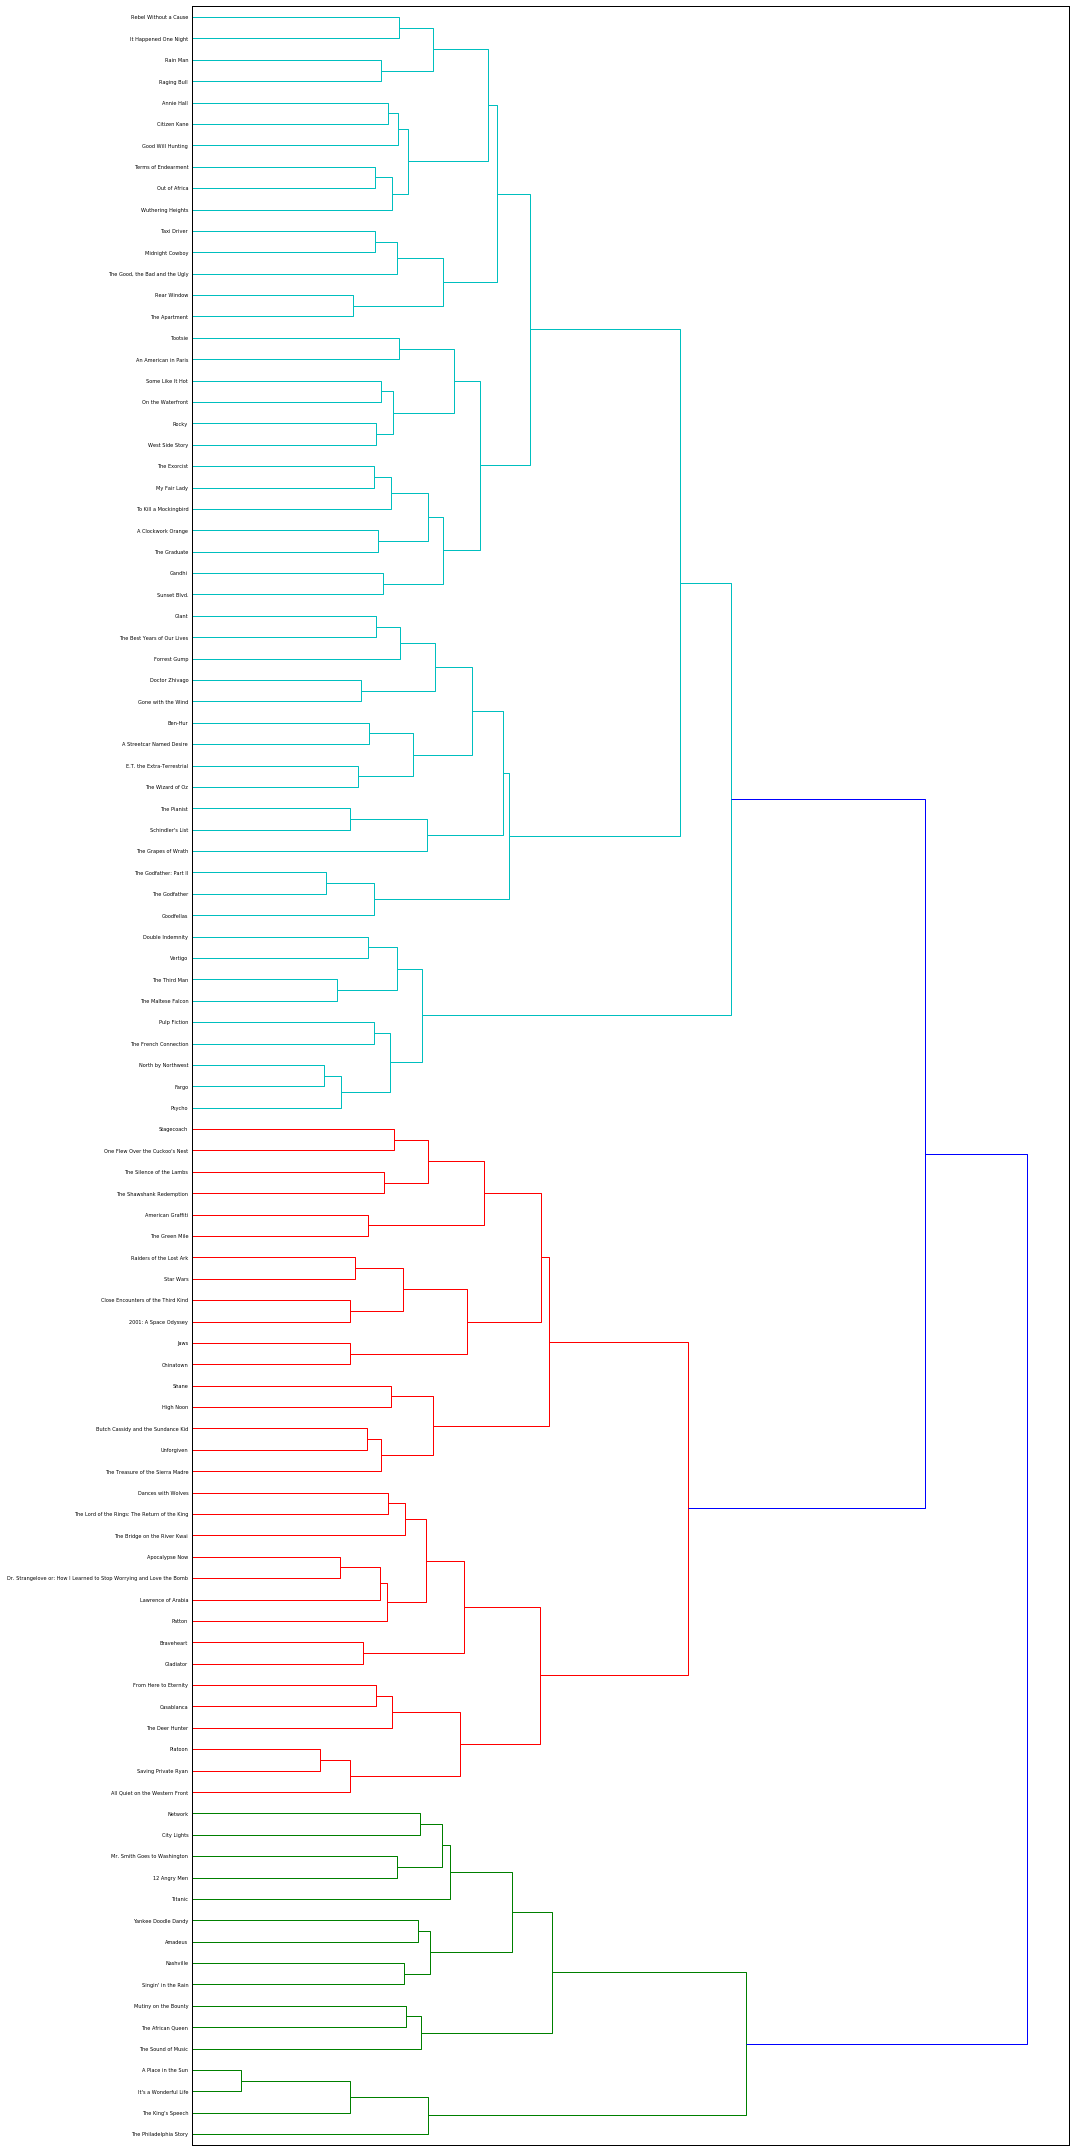

In [25]:
from scipy.cluster.hierarchy import ward, dendrogram

linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(15, 30)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels=titles);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

#uncomment below to save figure
plt.savefig('ward_clusters.png', dpi=200) #save figure as ward_clusters

Процесс иерархической кластеризации, как правило, изображается в виде дендрограммы, что позволяет наблюдать за процессом слияния, однако при использовании этого метода нет возможности получить какую-либо информацию о том, что общего у объектов каждого кластера.

## Латентное размещение Дирихле (LDA)

До сих пор при попытке выделить причины интереса к фильмам мы опирались лишь на конкретные слова, что приводило к неоднозначным результатам. Так происходит в том числе потому, что язык содержит синонимы, и одно слово может относиться к разным тематикам и нести разный смысл. При использовании признаков, основанных на отдельных словах, темы с похожими словарями будут смешиваться.

Будем считать, что каждый текст относится к некому малому числу тем, присутствующих в корпусе, а для каждого токена задана вероятность его присутствия в тексте соответствующей тематики. Данный подход называется тематическим моделированием и используется в том числе для выделения тематик из текстов.

Используем метод LDA, рассмотренный на лекции, для извлечения тематик из синопсисов. Для начала создадим словарь токенов на основе корпуса:

In [26]:
import string
def strip_proppers(text):
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent) if word.islower()]
    return "".join([" "+i if not i.startswith("'") and i not in string.punctuation else i for i in tokens]).strip()

In [28]:
from gensim import corpora, models, similarities 

preprocess = [strip_proppers(doc) for doc in synopses]

%time tokenized_text = [tokenize_and_preprocess(text) for text in preprocess]

%time texts = [[word for word in text if word not in stopwords] for text in tokenized_text]

CPU times: user 6.32 s, sys: 71.5 ms, total: 6.39 s
Wall time: 6.46 s
CPU times: user 681 ms, sys: 42 ms, total: 723 ms
Wall time: 698 ms


In [29]:
# dictionary is a set of tokens
dictionary = corpora.Dictionary(texts)
dictionary[3]

u'month'

А также отбросим слишком редкие и слишком частые слова (по аналогии с min_df и max_df):

In [30]:
dictionary.filter_extremes(no_below=1, no_above=0.8)

Несмотря на то, что LDA выделяет тематики текста, он также работает в предположении "мешка слов" — то есть предполагается, что все слова независимы, и произвольная перестановка слов в тексте ни на что не влияет. Поэтому каждый текст можно представлять в виде пар (токен, количество вхождений токена в текст):

In [31]:
corpus = [dictionary.doc2bow(text) for text in texts]
corpus[0]

[(1, 1),
 (15, 3),
 (24, 3),
 (27, 1),
 (35, 2),
 (44, 1),
 (55, 1),
 (60, 1),
 (63, 1),
 (66, 1),
 (68, 1),
 (91, 2),
 (100, 3),
 (107, 1),
 (110, 3),
 (112, 3),
 (140, 1),
 (146, 1),
 (167, 1),
 (173, 1),
 (195, 2),
 (216, 3),
 (222, 8),
 (226, 1),
 (230, 2),
 (243, 16),
 (245, 1),
 (256, 5),
 (263, 2),
 (264, 1),
 (267, 1),
 (268, 1),
 (281, 11),
 (297, 2),
 (311, 1),
 (315, 5),
 (323, 1),
 (330, 3),
 (337, 1),
 (362, 2),
 (381, 1),
 (385, 1),
 (386, 1),
 (387, 3),
 (388, 1),
 (404, 1),
 (408, 1),
 (419, 18),
 (424, 3),
 (432, 3),
 (435, 6),
 (450, 2),
 (454, 11),
 (461, 4),
 (462, 4),
 (465, 1),
 (475, 1),
 (486, 2),
 (487, 2),
 (493, 1),
 (512, 1),
 (533, 2),
 (535, 3),
 (545, 1),
 (554, 1),
 (560, 2),
 (563, 1),
 (585, 4),
 (586, 1),
 (597, 4),
 (616, 2),
 (625, 1),
 (632, 1),
 (636, 1),
 (643, 1),
 (658, 2),
 (667, 3),
 (668, 1),
 (674, 1),
 (695, 1),
 (706, 1),
 (712, 1),
 (715, 1),
 (727, 6),
 (733, 4),
 (803, 2),
 (822, 1),
 (832, 1),
 (852, 6),
 (854, 1),
 (861, 1),
 (869, 1

После приведения текстов к указанному виду можно строить соответствующую модель:

In [32]:
%time lda = models.LdaModel(corpus, num_topics=5, id2word=dictionary, update_every=5, chunksize=10000, passes=100, random_state=1)

CPU times: user 2min 58s, sys: 1.34 s, total: 2min 59s
Wall time: 3min 1s


Каждая из 5 выделенных тематик характеризуется наиболее вероятными токенами и значениями их вероятностей в рамках данной тематики $p(w|t):$

In [33]:
topics = lda.print_topics(5, num_words=20)
topics

[(0,
  u'0.004*"go" + 0.004*"say" + 0.004*"home" + 0.004*"day" + 0.004*"father" + 0.004*"ask" + 0.004*"n\'t" + 0.004*"love" + 0.004*"prison" + 0.003*"doe" + 0.003*"two" + 0.003*"friend" + 0.003*"arriv" + 0.003*"night" + 0.003*"also" + 0.003*"hous" + 0.003*"wife" + 0.003*"becaus" + 0.003*"name" + 0.003*"sing"'),
 (1,
  u'0.005*"famili" + 0.004*"love" + 0.004*"home" + 0.004*"car" + 0.004*"call" + 0.004*"meet" + 0.004*"friend" + 0.004*"work" + 0.004*"day" + 0.004*"becom" + 0.004*"ask" + 0.004*"two" + 0.003*"drive" + 0.003*"film" + 0.003*"run" + 0.003*"night" + 0.003*"next" + 0.003*"discov" + 0.003*"show" + 0.003*"apart"'),
 (2,
  u'0.008*"kill" + 0.006*"fight" + 0.004*"ask" + 0.004*"friend" + 0.004*"men" + 0.004*"arriv" + 0.004*"home" + 0.004*"go" + 0.004*"n\'t" + 0.004*"say" + 0.004*"two" + 0.004*"come" + 0.004*"soldier" + 0.003*"order" + 0.003*"meet" + 0.003*"run" + 0.003*"help" + 0.003*"father" + 0.003*"first" + 0.003*"goe"'),
 (3,
  u'0.008*"car" + 0.006*"meet" + 0.005*"go" + 0.005*"k

Полученное разбиение на тематики кажется более обоснованным, чем полученное ранее, — теперь, к примеру, слово kill по-прежнему фигурирует в различных топиках, однако улавливается общая смысловая составляющая объектов одного кластера — для кластера 3 речь идет о внутренних междоусобицах, а для кластера 2 — о войнах.

Можно также получить распределение на токенах для каждой из полученных тем:

In [34]:
topics_matrix = np.array([val for (key, val) in lda.show_topics(formatted=False, num_words=20)])
topics_matrix.shape

(5, 20, 2)

In [35]:
topics_matrix

array([[[u'go', u'0.00425737947701'],
        [u'say', u'0.00409405309589'],
        [u'home', u'0.00408511962372'],
        [u'day', u'0.00376847156373'],
        [u'father', u'0.0037396994642'],
        [u'ask', u'0.00368393551731'],
        [u"n't", u'0.0036245759187'],
        [u'love', u'0.00355353820119'],
        [u'prison', u'0.00352996592326'],
        [u'doe', u'0.00347445454621'],
        [u'two', u'0.00343274600165'],
        [u'friend', u'0.00337881802189'],
        [u'arriv', u'0.00331902531517'],
        [u'night', u'0.00326216454255'],
        [u'also', u'0.00321647085542'],
        [u'hous', u'0.00313230835407'],
        [u'wife', u'0.00313046484079'],
        [u'becaus', u'0.00312084921602'],
        [u'name', u'0.00290513557223'],
        [u'sing', u'0.00289391725561']],

       [[u'famili', u'0.00541413931551'],
        [u'love', u'0.00433890697156'],
        [u'home', u'0.00417492200853'],
        [u'car', u'0.00415617042132'],
        [u'call', u'0.00409685760462'

In [36]:
topic_words = topics_matrix[:,:,0]

for i in topic_words:
    print([str(word) for word in i])
    print()

['go', 'say', 'home', 'day', 'father', 'ask', "n't", 'love', 'prison', 'doe', 'two', 'friend', 'arriv', 'night', 'also', 'hous', 'wife', 'becaus', 'name', 'sing']

['famili', 'love', 'home', 'car', 'call', 'meet', 'friend', 'work', 'day', 'becom', 'ask', 'two', 'drive', 'film', 'run', 'night', 'next', 'discov', 'show', 'apart']

['kill', 'fight', 'ask', 'friend', 'men', 'arriv', 'home', 'go', "n't", 'say', 'two', 'come', 'soldier', 'order', 'meet', 'run', 'help', 'father', 'first', 'goe']

['car', 'meet', 'go', 'kill', 'famili', 'ask', 'polic', "n't", 'father', 'say', 'night', 'offic', 'room', 'goe', 'mother', 'stop', 'first', 'away', 'two', 'name']

['kill', 'shark', 'order', 'offic', 'attack', 'water', 'camp', 'attempt', 'men', 'soldier', 'command', 'boat', 'arriv', 'shoot', 'mission', 'villag', 'day', 'remain', 'night', 'tribe']



Зачастую методы тематического моделирования используют для формирования нового признакового пространства документов — для этого для каждого документа в качестве признаков рассматривают полученное распределение на топиках:

In [44]:
film_number = 0
print(titles[film_number], lda[corpus[film_number]])

The Godfather [(1, 0.83335598490291862), (2, 0.15081307480701012), (3, 0.015582792760442096)]


In [45]:
film_number = 0
print(titles[film_number], lda.get_document_topics(corpus[film_number], minimum_probability=0))

The Godfather [(0, 0.00012399376171560279), (1, 0.83377753059284532), (2, 0.15114214746453961), (3, 0.014832173442276959), (4, 0.00012415473862254555)]


Используем новые признаки для поиска похожих фильмов и визуализации, как ранее:

In [39]:
topics_matrix = np.array([[doc_topic_prob[1] for doc_topic_prob in lda.get_document_topics(doc, minimum_probability=0)] for doc in corpus])
topics_matrix

array([[  1.23992989e-04,   8.33446252e-01,   1.50865398e-01,
          1.54402024e-02,   1.24154828e-04],
       [  9.99495795e-01,   1.25934961e-04,   1.26464866e-04,
          1.25828721e-04,   1.25976372e-04],
       [  1.91426935e-04,   1.91186438e-04,   1.90891495e-04,
          1.90952409e-04,   9.99235543e-01],
       [  2.12392687e-04,   3.91051796e-02,   9.60260601e-01,
          2.11236839e-04,   2.10589447e-04],
       [  9.98172775e-01,   2.39119871e-04,   1.10839882e-03,
          2.39425330e-04,   2.40280969e-04],
       [  1.31671173e-01,   1.42425860e-03,   1.58949169e-04,
          1.58668718e-04,   8.66586951e-01],
       [  8.73431085e-01,   1.64369170e-03,   1.24756158e-01,
          8.44249631e-05,   8.46404537e-05],
       [  1.90352812e-04,   9.99241931e-01,   1.89320137e-04,
          1.89399070e-04,   1.88997001e-04],
       [  2.10924268e-04,   2.11300769e-04,   9.99157014e-01,
          2.10455857e-04,   2.10305420e-04],
       [  2.65016526e-04,   2.6467511

In [40]:
dist_topics = 1 - cosine_similarity(topics_matrix)
dist_topics = np.maximum(np.zeros(dist.shape), dist) # overriding precision errors
pd.DataFrame(dist_topics)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.000000,0.800540,0.762813,0.754917,0.734714,0.798842,0.579230,7.406224e-01,7.205814e-01,0.875165,...,0.634593,0.744356,0.729301,0.800025,0.664344,0.664176,0.773151,0.641312,6.705782e-01,0.823926
1,0.800540,0.000000,0.733478,0.825432,0.767897,0.705784,0.735097,8.080429e-01,7.768603e-01,0.872037,...,0.721570,0.529899,0.798735,0.831396,0.812697,0.881068,0.817880,0.733118,7.716092e-01,0.892975
2,0.762813,0.733478,0.000000,0.813207,0.710407,0.786592,0.604588,7.714040e-01,7.813395e-01,0.837482,...,0.796111,0.792054,0.774655,0.836437,0.800423,0.900050,0.817346,0.723807,7.494897e-01,0.858673
3,0.754917,0.825432,0.813207,0.000000,0.823794,0.824472,0.716148,6.918142e-01,8.722325e-01,0.876853,...,0.818708,0.780351,0.745104,0.800379,0.813221,0.822593,0.796196,0.765148,7.694794e-01,0.876888
4,0.734714,0.767897,0.710407,0.823794,0.000000,0.694266,0.660453,7.538627e-01,7.388473e-01,0.881802,...,0.671814,0.782382,0.734990,0.813092,0.614949,0.782968,0.766356,0.605218,6.320344e-01,0.804208
5,0.798842,0.705784,0.786592,0.824472,0.694266,0.000000,0.750991,7.868591e-01,7.226483e-01,0.854346,...,0.772842,0.641621,0.762121,0.748385,0.811850,0.867853,0.718264,0.669482,6.563999e-01,0.922110
6,0.579230,0.735097,0.604588,0.716148,0.660453,0.750991,0.000000,6.537296e-01,6.315202e-01,0.802409,...,0.671313,0.709579,0.686691,0.621620,0.671187,0.771724,0.739278,0.604365,6.278072e-01,0.778311
7,0.740622,0.808043,0.771404,0.691814,0.753863,0.786859,0.653730,2.220446e-16,8.273514e-01,0.794043,...,0.764814,0.689357,0.715340,0.740639,0.747380,0.807657,0.767651,0.763425,6.962482e-01,0.823697
8,0.720581,0.776860,0.781339,0.872233,0.738847,0.722648,0.631520,8.273514e-01,3.330669e-16,0.841057,...,0.755200,0.762186,0.742391,0.786411,0.794418,0.887258,0.769376,0.704912,6.673681e-01,0.846397
9,0.875165,0.872037,0.837482,0.876853,0.881802,0.854346,0.802409,7.940427e-01,8.410573e-01,0.000000,...,0.817777,0.831667,0.793370,0.879104,0.831353,0.876718,0.870285,0.836936,7.621334e-01,0.942701


In [41]:
film_number = 0

print(titles[film_number])
print([titles[i] for i in dist_topics[film_number, :].argsort()[:10]])

The Godfather
['The Godfather', 'The Godfather: Part II', 'Goodfellas', 'Giant', 'Doctor Zhivago', 'Gladiator', 'Gone with the Wind', 'Saving Private Ryan', 'The Pianist', 'On the Waterfront']


In [42]:
%time km.fit(topics_matrix)

clusters = km.labels_.tolist()

films = { 'title': titles, 'rank': ranks, 'synopsis': synopses, 'cluster': clusters, 'genre': genres }
frame = pd.DataFrame(films, index = [clusters] , columns = ['rank', 'title', 'cluster', 'genre'])
frame

CPU times: user 14.2 ms, sys: 1.54 ms, total: 15.8 ms
Wall time: 14.9 ms


,rank,title,cluster,genre
2,0,The Godfather,2,"[u' Crime', u' Drama']"
0,1,The Shawshank Redemption,0,"[u' Crime', u' Drama']"
4,2,Schindler's List,4,"[u' Biography', u' Drama', u' History']"
1,3,Raging Bull,1,"[u' Biography', u' Drama', u' Sport']"
0,4,Casablanca,0,"[u' Drama', u' Romance', u' War']"
4,5,One Flew Over the Cuckoo's Nest,4,[u' Drama']
0,6,Gone with the Wind,0,"[u' Drama', u' Romance', u' War']"
2,7,Citizen Kane,2,"[u' Drama', u' Mystery']"
1,8,The Wizard of Oz,1,"[u' Adventure', u' Family', u' Fantasy', u' Mu..."
3,9,Titanic,3,"[u' Drama', u' Romance']"


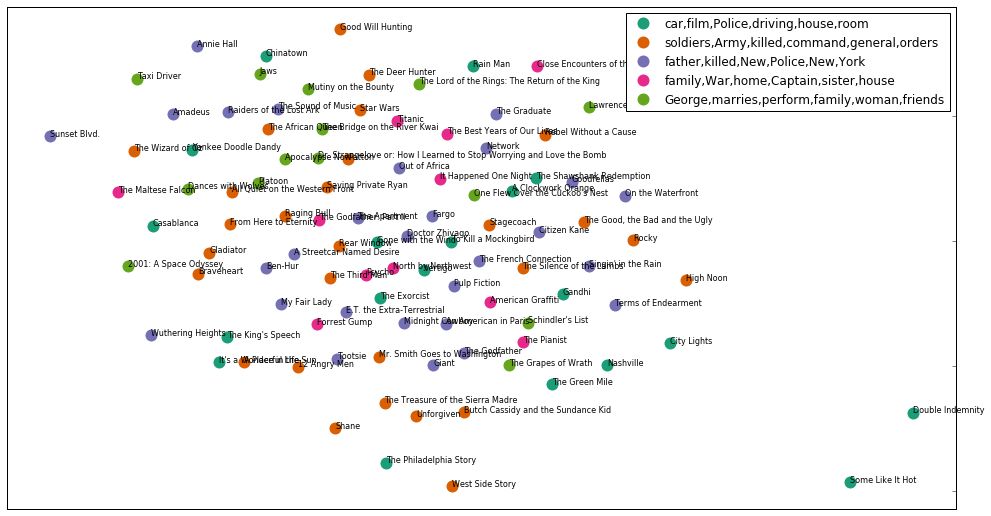

In [43]:
tsne = TSNE(n_components=2, metric="precomputed", random_state=1)

pos = tsne.fit_transform(dist_topics)

xs, ys = pos[:, 0], pos[:, 1]

cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}

cluster_names = {i: ','.join(['%s' % vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore') for ind in order_centroids[i, :6]])
                 for i in range(5)}

df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 


groups = df.groupby('label')



fig, ax = plt.subplots(figsize=(17, 9))
ax.margins(0.05)

for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, label=cluster_names[name], color=cluster_colors[name], mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',
        which='both',
        bottom='off',
        top='off',
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',
        which='both',
        left='off',
        top='off',
        labelleft='off')
    
ax.legend(numpoints=1)

for i in range(len(df)):
    ax.text(df.ix[i]['x'], df.ix[i]['y'], df.ix[i]['title'], size=8)  

plt.show()

## Материалы

* [Анализ дневника Марты Баллард](http://www.cameronblevins.org/posts/topic-modeling-martha-ballards-diary/)
* [Анализ текстов газет во время гражданской войны в США](http://dsl.richmond.edu/dispatch/pages/intro)
* [Document clustering with Python](http://brandonrose.org/clustering)